In [1]:
from functools import partial

import pandas as pd
import src.utils as utils
import src.content as content

In [2]:
metrics = utils.load_all_metric_files()

In [3]:
# This automatically picks the latest month in the data as the reporting period but you
# can replace the line to manually specify any month you choose.
# For example: `month_to_report = pd.Period("2023-06", freq="M")`

month_to_report = metrics.index[-1]
calculate_report = partial(utils.calc_rpt, reporting_period=month_to_report)
format_report = partial(utils.format_report, reporting_period=month_to_report)

## Essential metrics report

In [4]:
essential_metrics = [
    "interactions",
    "unique_devices",
    "northern_western_europe_unique_devices",
    "north_america_unique_devices",
    "east_southeast_asia_pacific_unique_devices",
    "central_eastern_europe_central_asia_unique_devices",
    "latin_america_caribbean_unique_devices",
    "middle_east_north_africa_unique_devices",
    "south_asia_unique_devices",
    "subsaharan_africa_unique_devices",
    "active_editors",
    "returning_active_editors",
    "new_active_editors",
    "net_new_Wikipedia_articles",
    "net_new_Commons_content_pages",
    "net_new_Wikidata_entities",
]


(
    metrics
    .reindex(essential_metrics, axis="columns")
    .apply(calculate_report)
    .transpose()
    .pipe(format_report, metrics_type="essential")

)


## Core annual plan metrics report

In [5]:
core_metrics = [
    # % new quality biography articles about women and gender-diverse people
    # % new quality articles about regions that are underrepresented
    "unique_devices",
    "south_asia_unique_devices",
    "latin_america_caribbean_unique_devices",
    "north_america_unique_devices",
    "northern_western_europe_unique_devices"
]

(
    metrics
    .reindex(core_metrics, axis="columns")
    .apply(calculate_report)
    .transpose()
    .pipe(format_report, metrics_type="core")
)

# Content Gap Metrics

In [6]:
#    The monthly metrics for the content gap data is calculated as the Month over Month change in new articles about 1) underrepresented wmf regions and 2) biographies of gender minorities (female and gender diverse)
#    as a proportion of the total new articles Month over Month respectively.
#    The naive forecast is calculated as the rate of change from the same month last year to the subsequent month multiplied by the current month's proportion.


minorities = [
    "underrepresented_regions_net_new_articles_sum", 
    "gender_minorities_net_new_articles_sum"
]

totals = [
    "all_regions_net_new_articles_sum",
    "all_genders_net_new_articles_sum"
]

index_names = [
    "% new quality articles about regions that are underrepresented", 
    "% new quality biography articles about women and gender-diverse people"
]

# Check if any value in the 'minorities' or 'totals' columns for the 'month_to_report' row is NaN and removes that month.
# Content metrics gap data is released a few weeks after the rest of the metrics data is released.



if metrics.loc[month_to_report, minorities + totals].isna().any():
    month_to_report = metrics.index[-2]

(
    metrics
    .pipe(content.calc_content_rpt, month_to_report, minorities, totals, index_names)
    .transpose()
    .pipe(format_report, metrics_type="Content Gap Metrics", reporting_period=month_to_report)
)

## Core annual plan and essential metric charts

Changing directory to:/srv/home/hghani/2024-01-04/wikicharts
Generating Content Interactions chart...


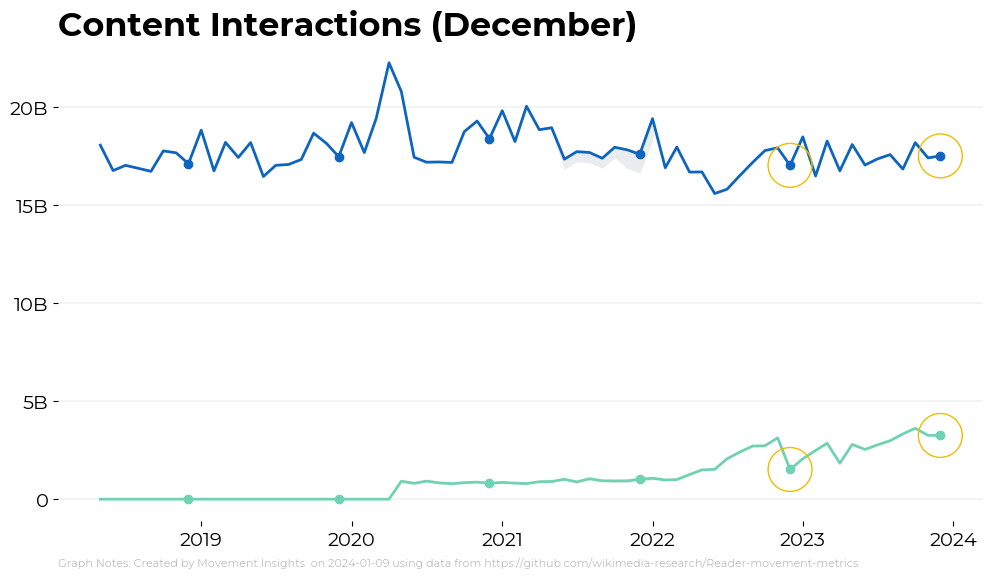

Generating Content Interactions chart...


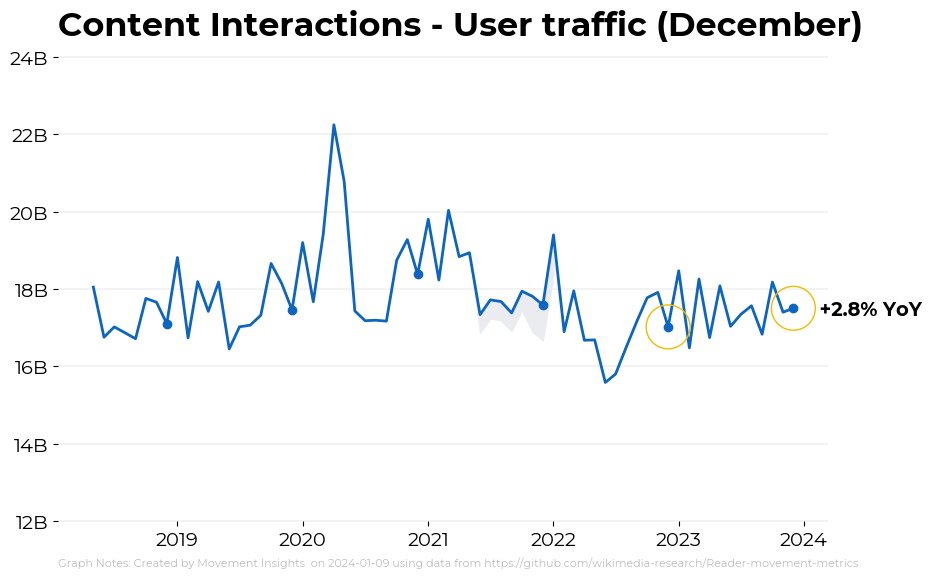

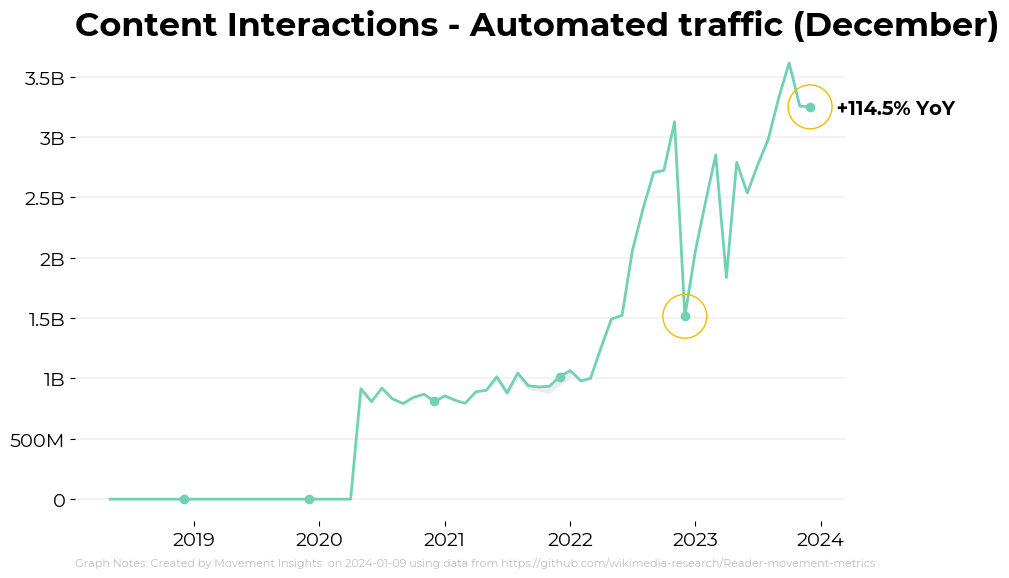

Generating Unique Devices chart...
Formatting may look incorrect in jupyter notebook window but the saved chart image will still be correct.


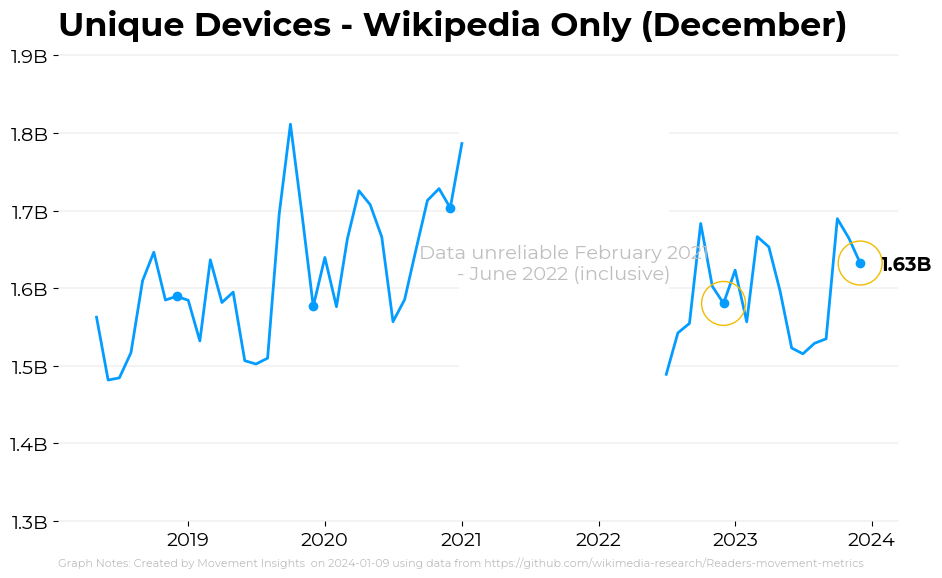

Generating Regional Unique Devices chart...
Formatting may look incorrect in jupyter notebook window but the saved chart image will still be correct.


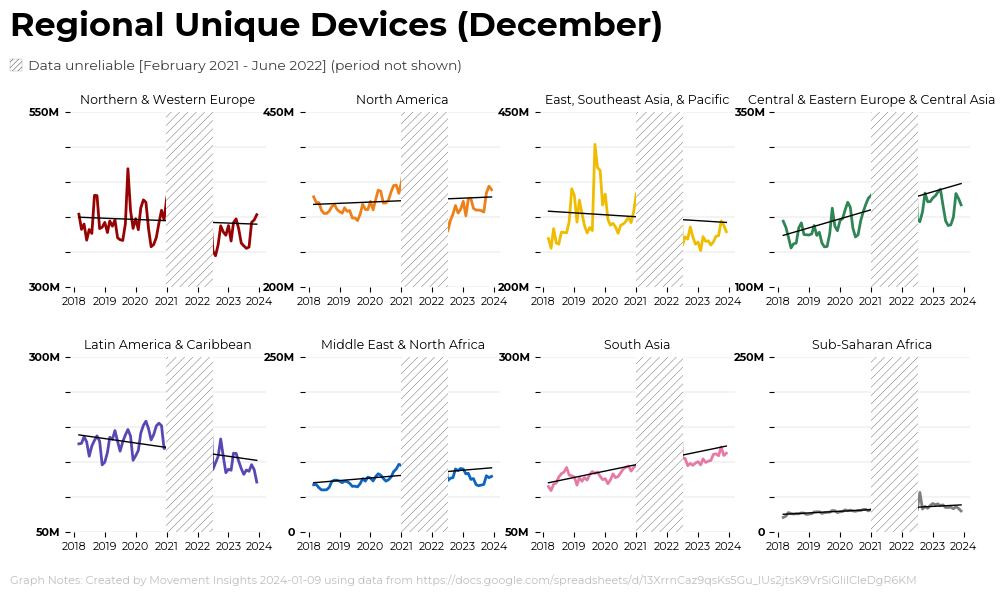

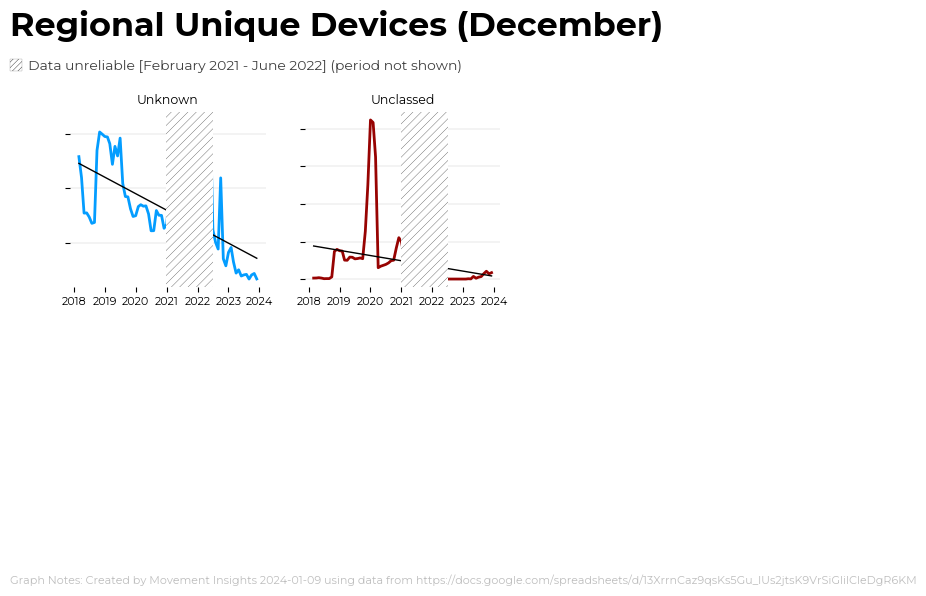

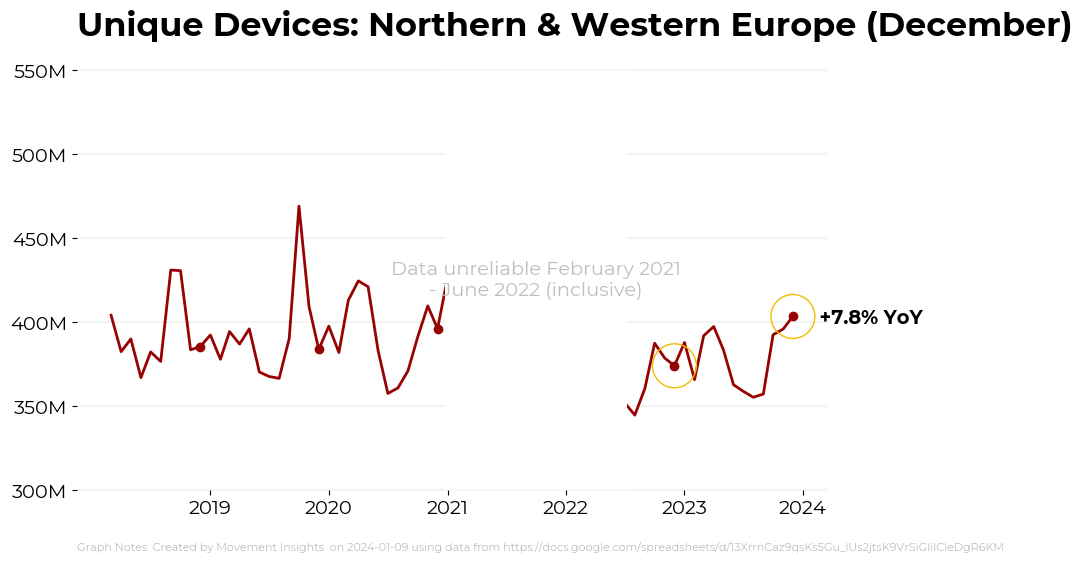

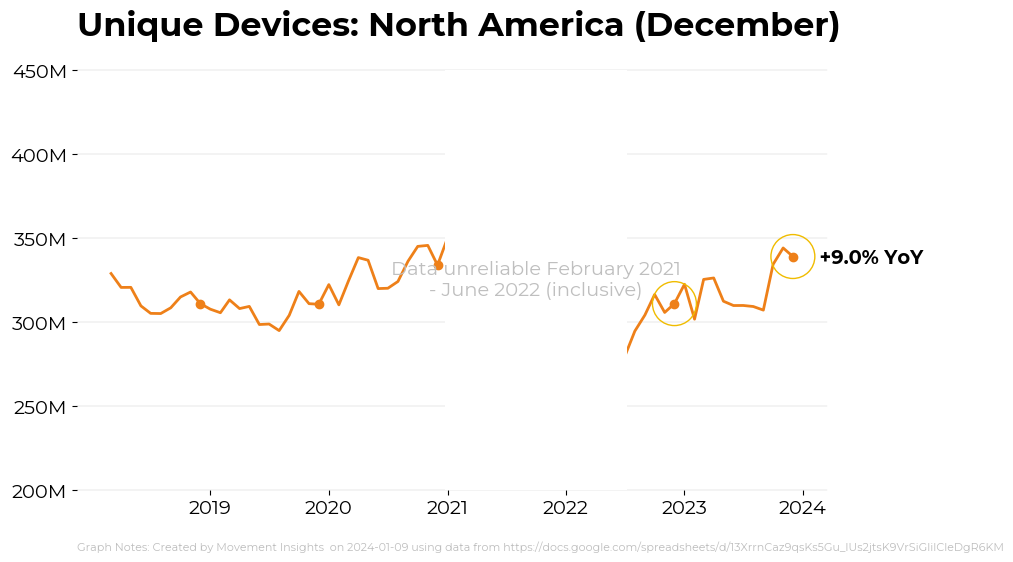

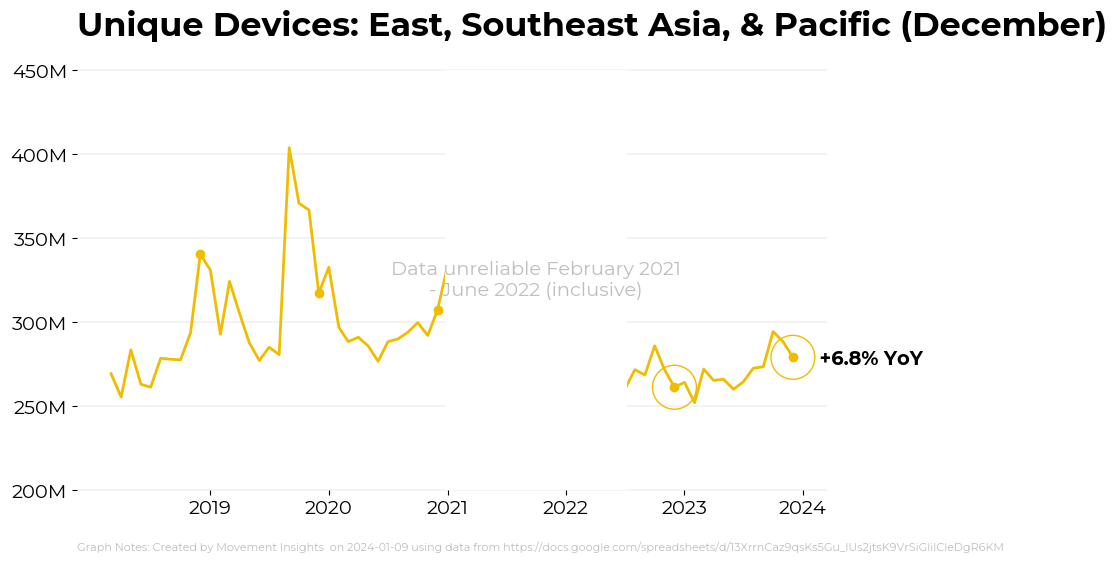

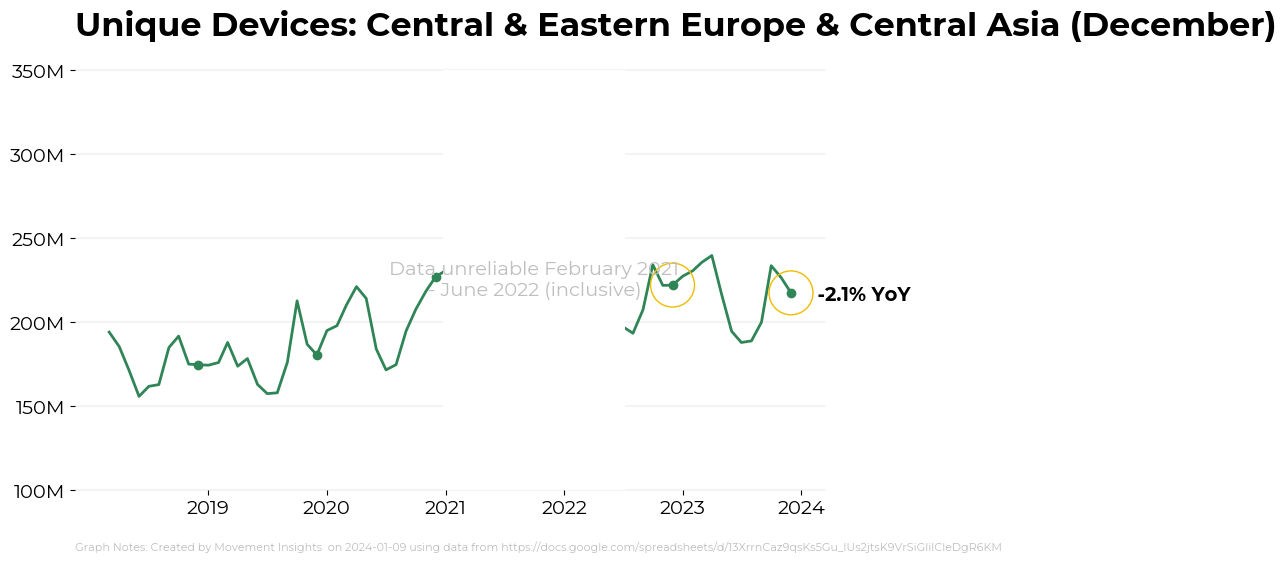

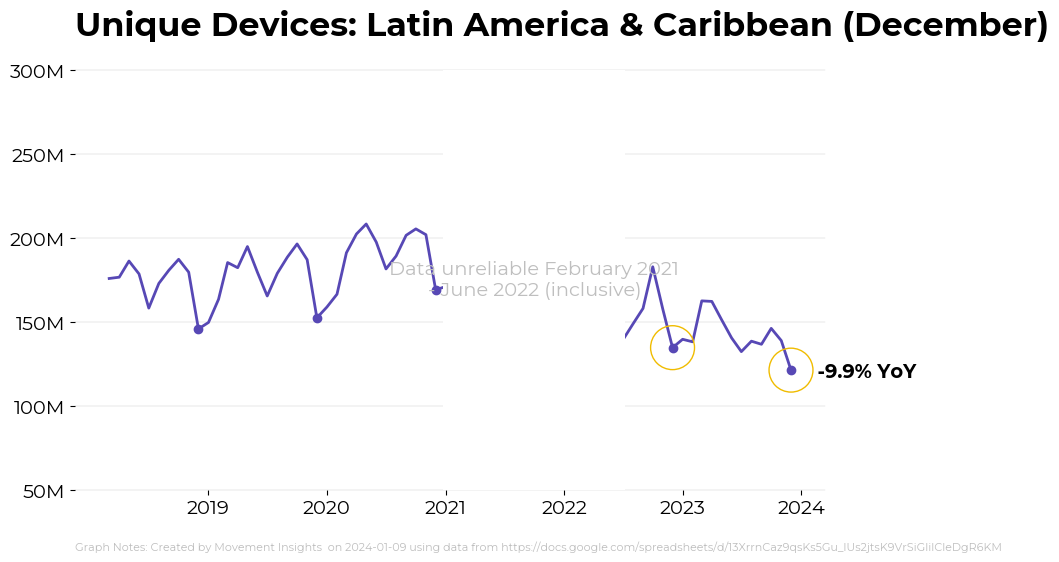

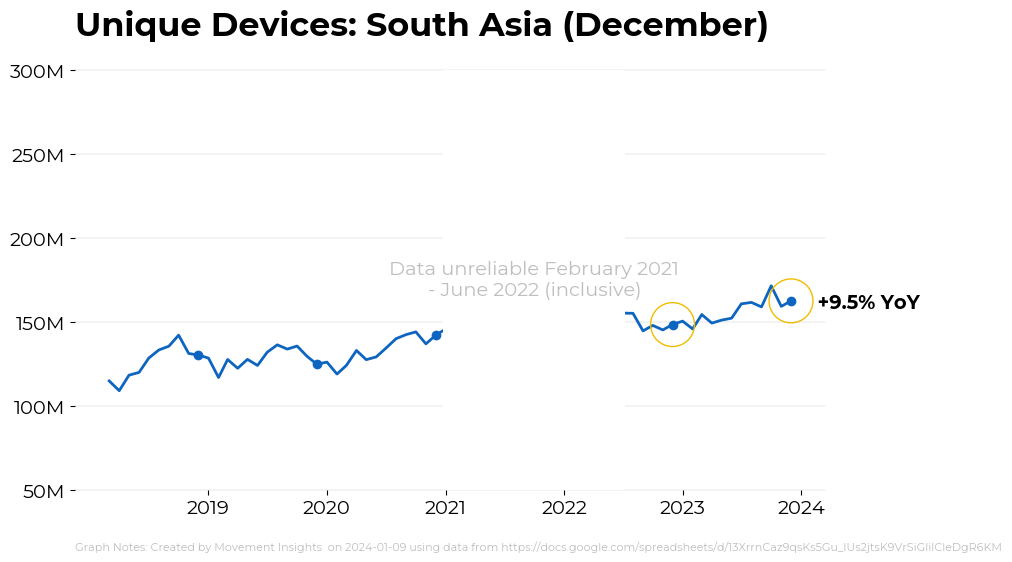

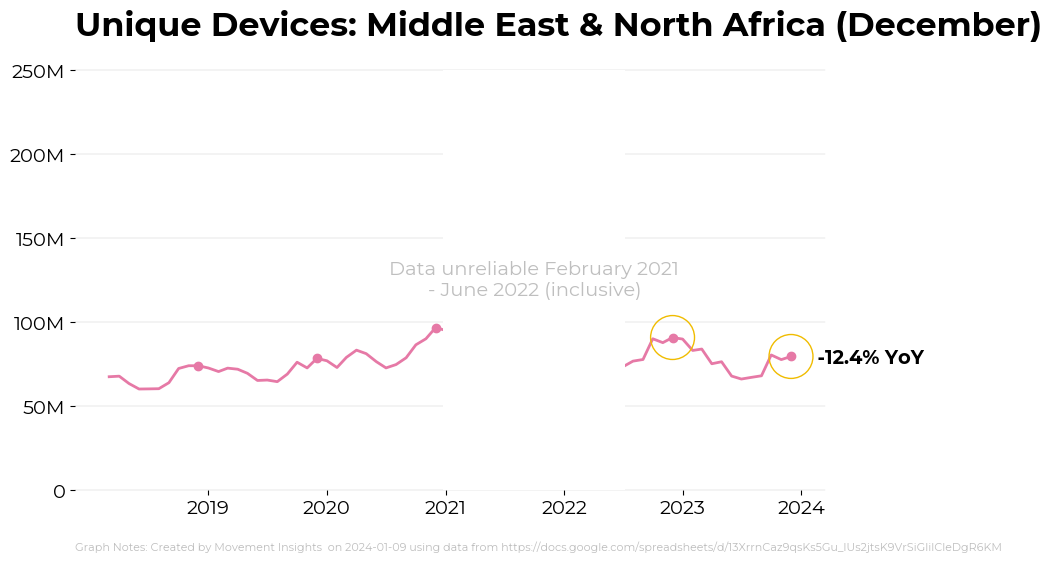

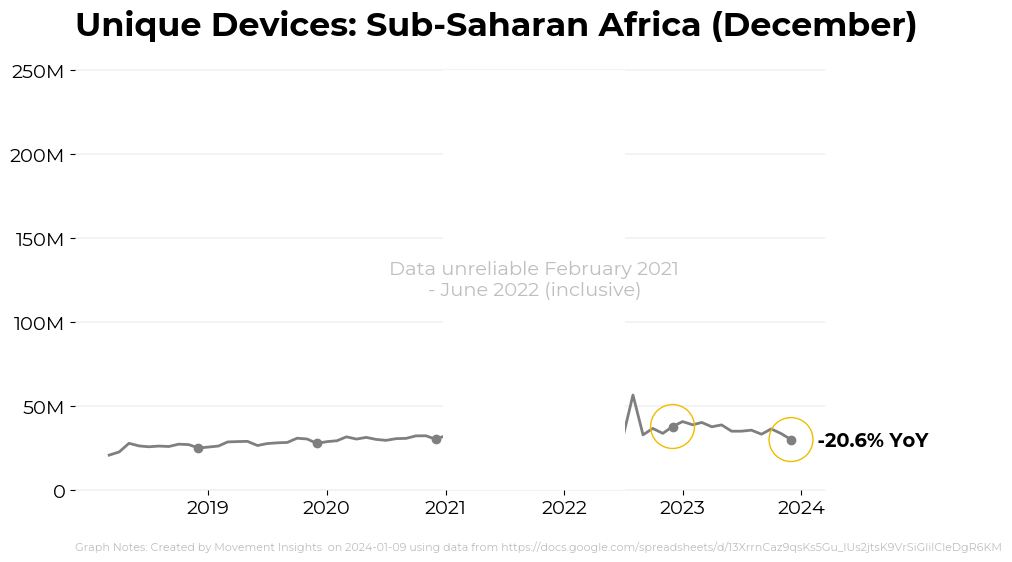

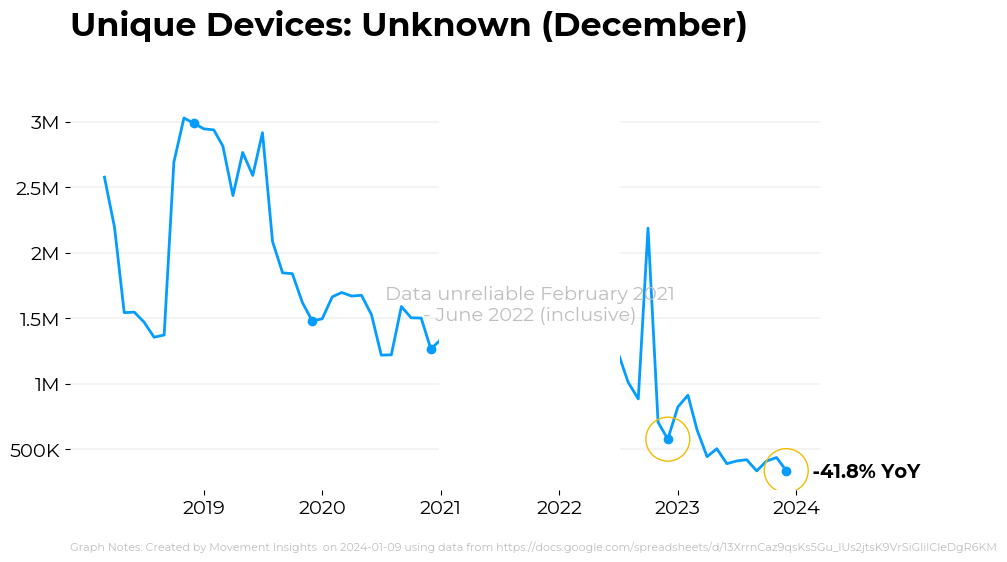

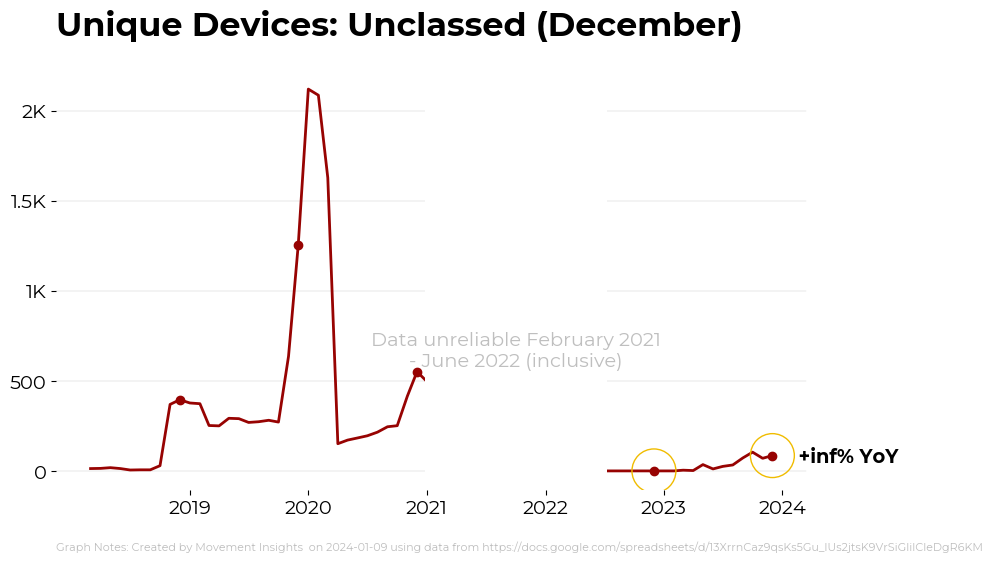

Generating Active Editors chart...


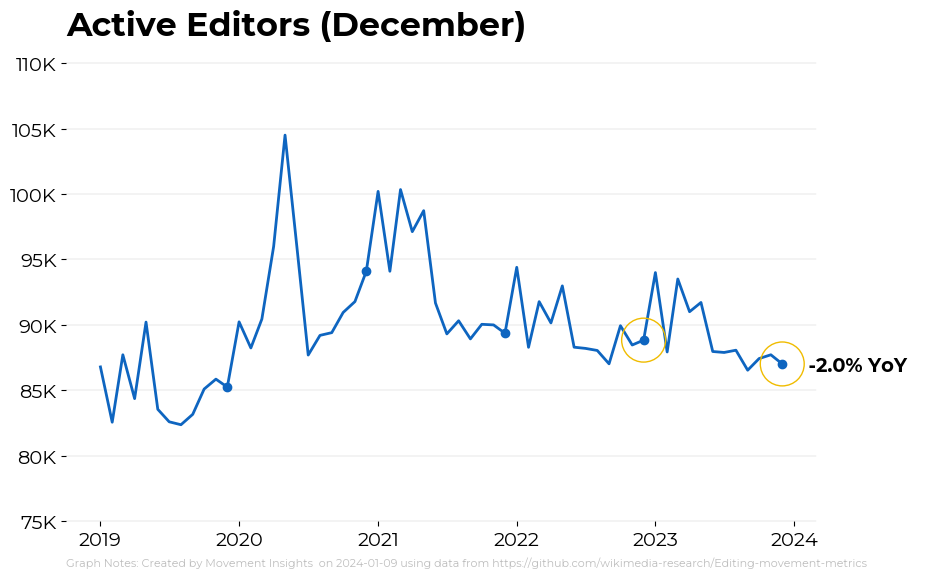

Generating New Returning chart...


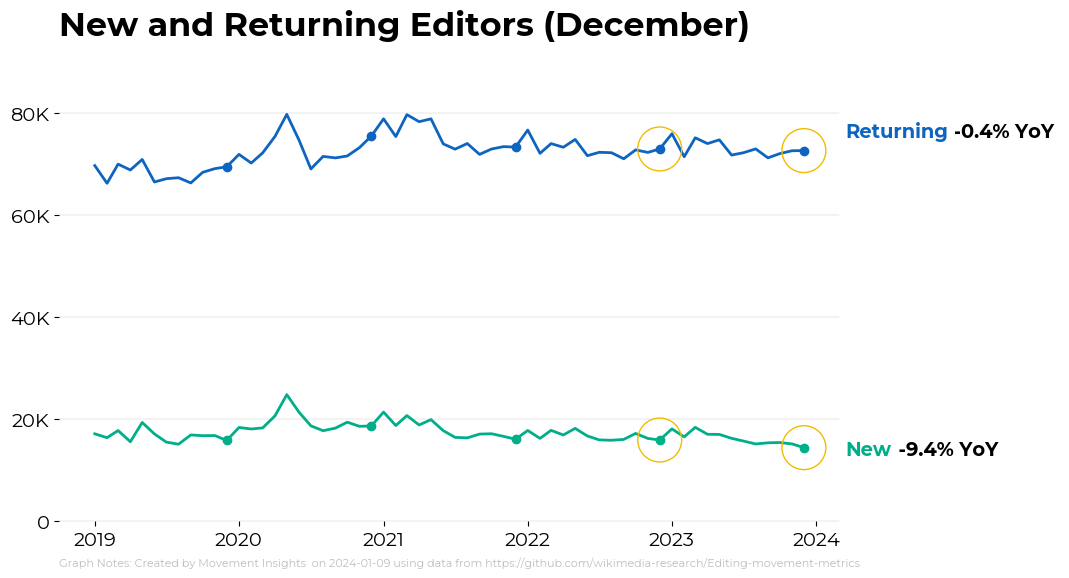

SPARK_HOME: /usr/lib/spark3
Using Hadoop client lib jars at 3.2.0, provided by Spark.
PYSPARK_PYTHON=/opt/conda-analytics/bin/python3


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/09 16:23:33 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/01/09 16:23:35 WARN Utils: Service 'sparkDriver' could not bind on port 12000. Attempting port 12001.
24/01/09 16:23:35 WARN Utils: Service 'sparkDriver' could not bind on port 12001. Attempting port 12002.
24/01/09 16:23:35 WARN Utils: Service 'sparkDriver' could not bind on port 12002. Attempting port 12003.
24/01/09 16:23:35 WARN Utils: Service 'sparkDriver' could not bind on port 12003. Attempting port 12004.
24/01/09 16:23:35 WARN Utils: Service 'sparkDriver' could not bind on port 12004. Attempting port 12005.
24/01/09 16:23:35 WARN Utils: Service 'sparkDriver' could not bind on port 12005. Attempting port 12006.
24/01/09 16:23:35 WARN Utils: Service 'spar

Generating Regional Active Editors chart...


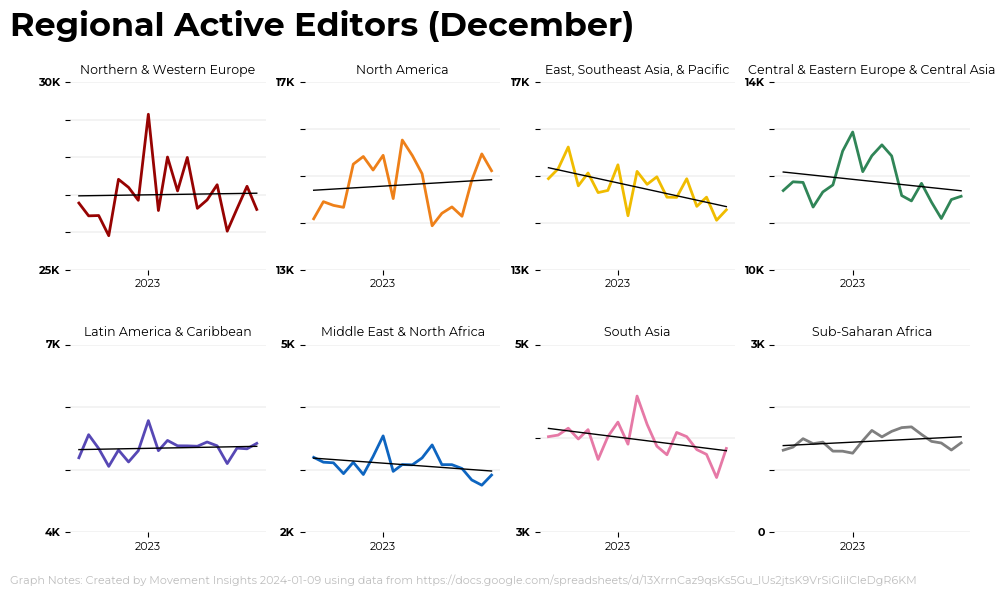

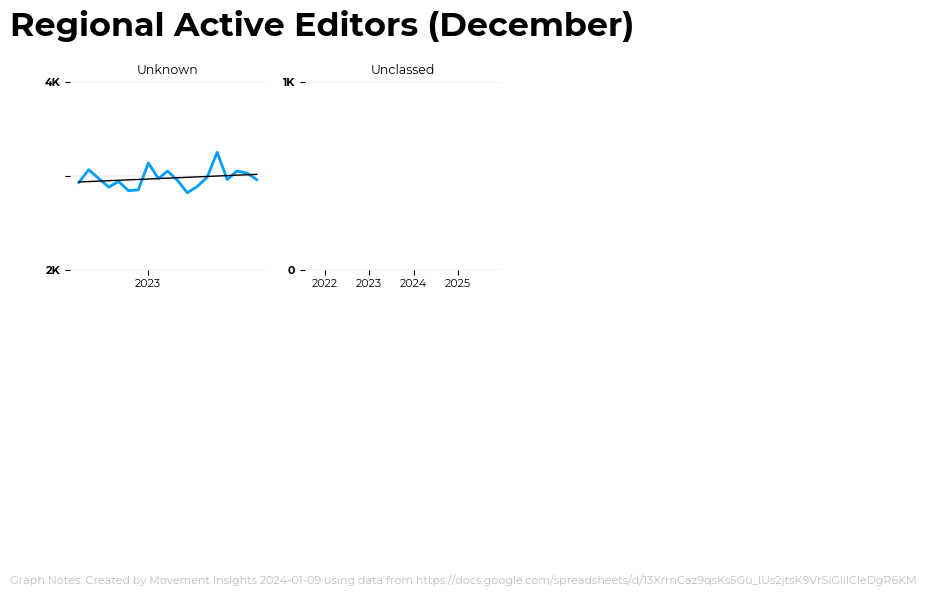

Generating Net New Content chart...


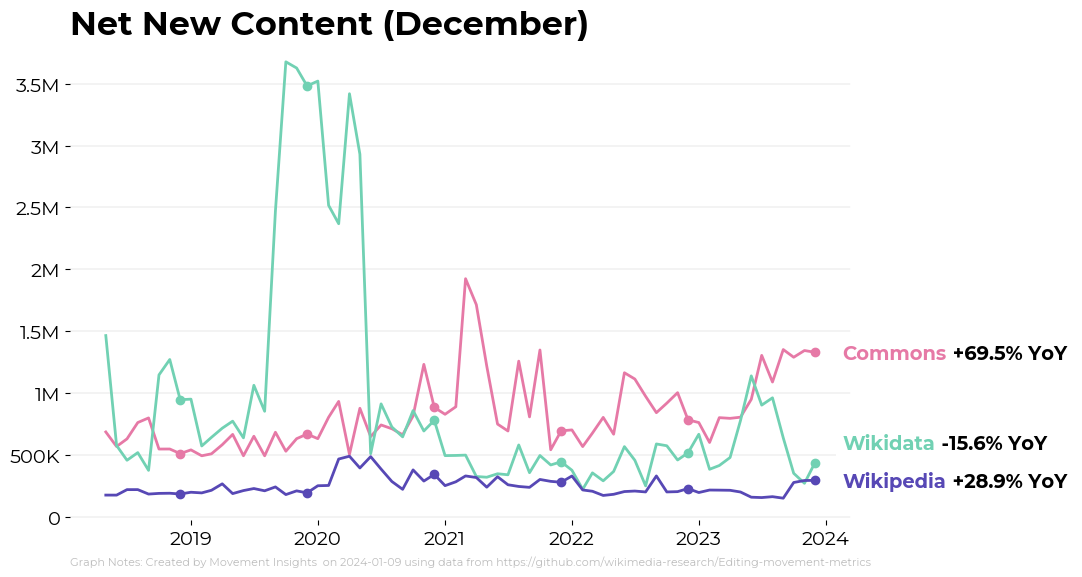

Generating region chart..


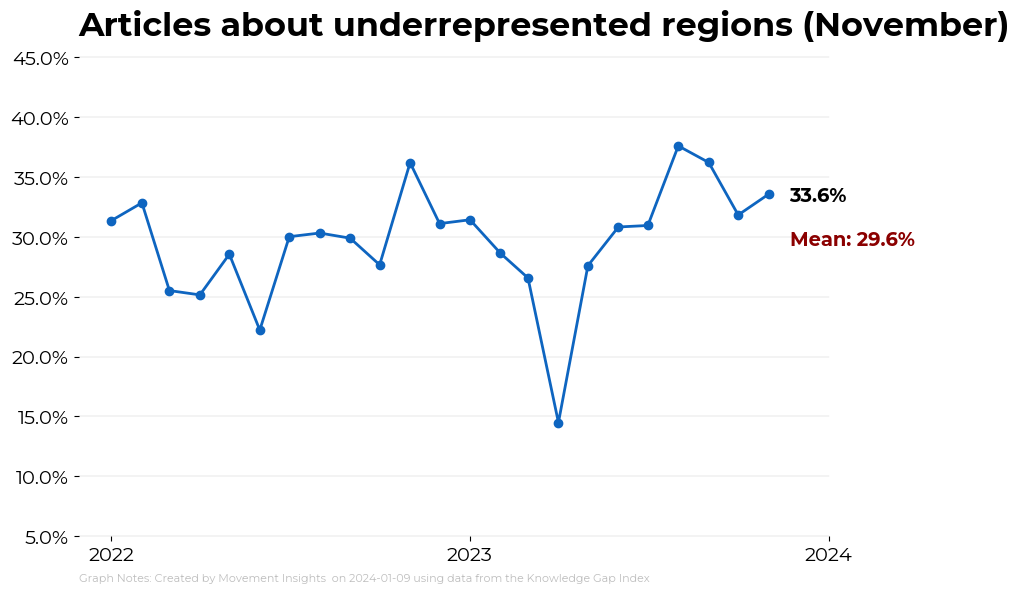

Generating Women % Distribution chart...


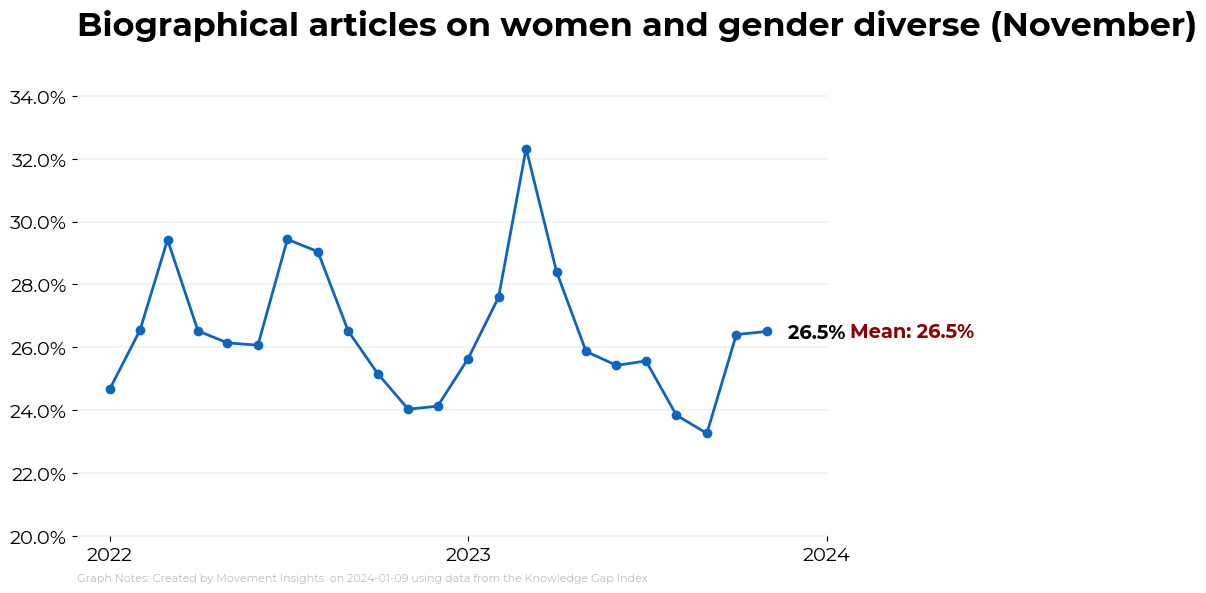

Resetting directory to:/srv/home/hghani/2024-01-04/wikicharts


In [7]:
%run "wikicharts/CORE_AND_ESSENTIAL_METRICS.ipynb"